In [42]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [43]:
#install.packages("gbm")
#install.packages("xgboost")
#install.packages("doParallel")

In [44]:
library(dplyr)

# Modeling packages
library(caret)
library(gbm)      # for original implementation of regular and stochastic GBMs
library(xgboost)  # for fitting extreme gradient boosting
library(gridExtra)
library(vip)
library(recipes)




# Loss function
La *loss function* es una medida que indica que tan bien los parámetros del modelo ajustan a los datos de entrenamiento y en general minimizan el error. Para los problemas de regresión se suele usar **Suma del error cuadratico/SSE** dado que es diferenciable y eso facilita el proceso de optimización de los algoritmos.  
Como vimos en la clase de árboles se suele usar la SSE como criterio para hacer la busqueda del mejor split en un nodo (feature, threshold). Adicionalmente en el caso de las técnicas de boosting se usa la misma función para buscar en cada iteración el mejor árbol para reducir el error.

<img src="https://miro.medium.com/max/548/1*rdBw0E-My8Gu3f_BOB6GMA.png">


# GBM

**Hyperparameters**
La versión clásica de GBM tiene 2 tipos de hiper-parámetros:
   * boosting
   * específicos de los árboles

**Hiper-parámetros de Boosting**
* **Numero de arboles**: el número total de árboles en la secuencia. A diferencia de Bagging y RF donde el número de árboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del árbol anterior lo hace propenso a hacer overfitting, en general este número puede variar en dependencia de los otros hiper-parámetros.
* **Learning rate (shrinkage)**: determina la contribución de cada árbol en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores típicos van entre $0.001$ - $0.3$. Valores más pequeños hacen más robusto a características específicas de cada árbol, permitiendo generalizar bien. Sin embargo, los valores pequeños pueden llevar a no encontrar el punto óptimo y quedar en un mínimo local. Generalmente valores más pequeños logran una mejor performance pero requiere de un número mayor de árboles en la secuencia.

**Hiper-parámetros propios de cada árbol**

* **Profundidad del árbol**: Controla la profundidad máxima de cada árbol. Los valores típicos van entre 3-8 pero no es raro ver árboles con profundidad 1. Valores bajos son computacionalmente eficiente pero requiere de más árboles en total. Sin embargo, los valores más grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Número mínimo de observaciones en un nodo**: controla la complejidad del árbol. Dado que los árboles tienden a ser poco profundos tiende a tener poco efecto. Valores típicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy específicas entre variables (overfitting) pero para los casos de datasets desbalanceados, los valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.


# Load data

In [45]:
ames <- AmesHousing::make_ames()

response <- "Sale_Price"
predictors <- setdiff(colnames(ames), response)

# Split Dataset

In [46]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

# Modeling
## Basic GBM model


In [47]:
set.seed(123)  # for reproducibility
ames_gbm1 <- gbm(
  formula = Sale_Price ~ .,
  data = house_train,
  distribution = "gaussian",  # SSE loss function
  n.trees = 1000,  # default = 100
  shrinkage = 0.1,  # default = 0.1
  interaction.depth = 3,  # max tree depth
  n.minobsinnode = 10,  # min obserbation in a node
  bag.fraction = 0.5,
  cv.folds = 5
)

# Busca el numero de arboles que genera el menor error en train
best <- which.min(ames_gbm1$cv.error)

# calcula el RMSE de train para el numero de arboles con el minimo MSE
sqrt(ames_gbm1$cv.error[best])
## [1] 23240.38

[1] 21796.03

## Plot error curve and find the optimum iteration

[1] 655

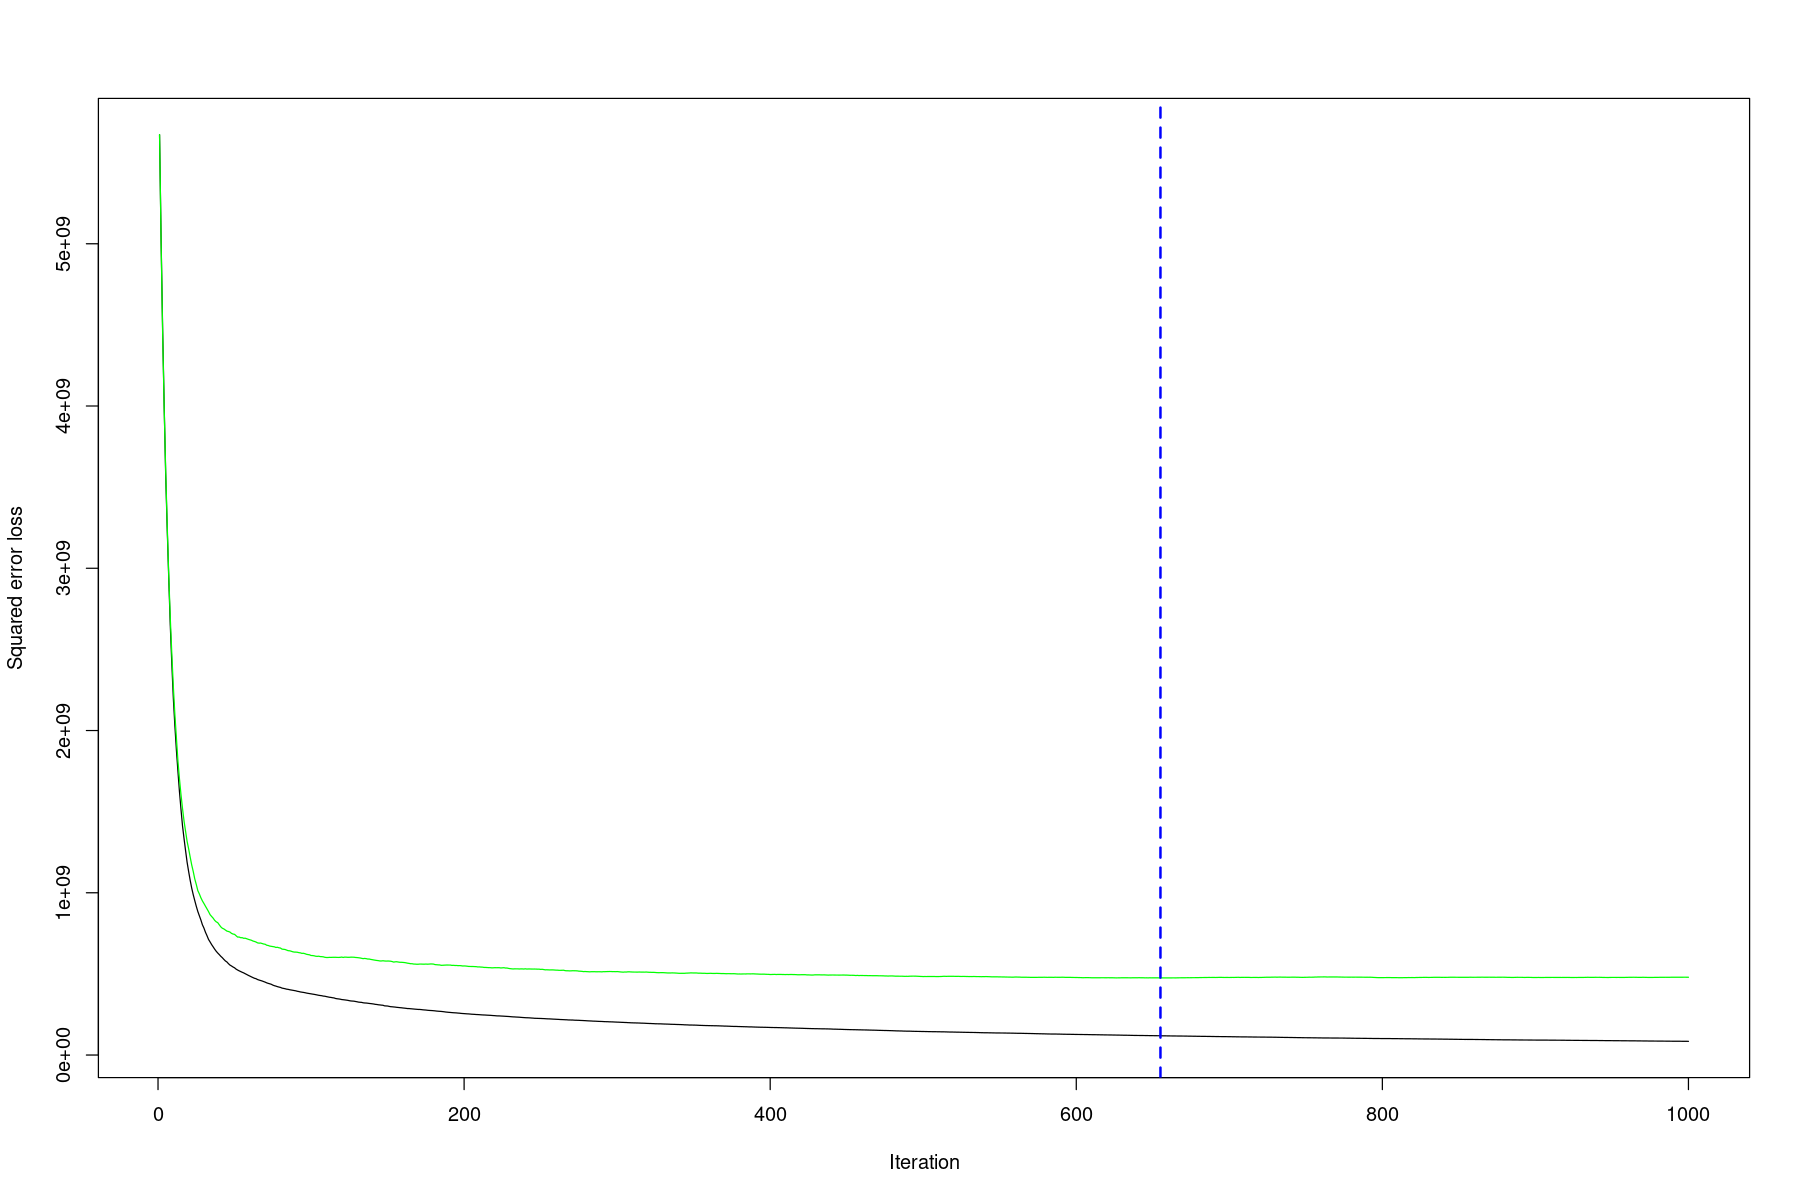

In [48]:
gbm.perf(ames_gbm1, method = "cv")

## Predictions
Hay algunas diferencias en la forma en la que se hacen las predicciones con nuevos datos usando GBM, ademas de dar el modelo y los nuevos datos podemos indicar el numero de iteraciones (numero de arboles) para la prediccion, por defecto usa el que resulto de gbm.perf(..., method=CV).

In [49]:
RMSE(pred = predict(ames_gbm1, newdata = house_test, n.trees = NULL, type = 'response'),
     obs = house_test$Sale_Price)

Using 655 trees...




[1] 21516.79

# General tuning strategy
A diferencia de Random Forest, GBM tiene una alta variabilidad en las métricas de performance dependiendo de los valores que definamos para el modelo. De esta forma tenemos que tener mayor entendimiento del efecto de cada hiper-parámetro y definir una estrategia más elaborada que en RF. En general un buen plan es:

* Elegir un learning rate (*lr*) alto. Por lo general el valor por defecto es 0.1 pero puede variar entre 0.05-0.3 dependiendo del problema.
* Determina el número óptimo de iteraciones/árboles para ese *lr*.
* Modifica los hiper-parámetros de los árboles
* Explora disminuir el *lr* en búsqueda de pequeñas mejoras
* Si en los pasos anteriores no utilizaste CV entrena con los mejores hiperparametros y usa CV para obtener resultados más robustos.

# Stochastic GBMs
Una de las grandes contribuciones de Breiman (el creador de bagging y RF) fue la idea de introducir muestras aleatorias en en el proceso de entrenamiento del modelo reduciendo la correlación entre los modelos lo que ayuda a mejorar el performance. Estas ideas fueron introducidas también en bagging para reducir el overfitting y ayudar a encontrar el mínimo global del error. Este procedimiento es conocido con *stochastic gradient boosting*.

Algunas de las variaciones de esta mejora son:
1. **Muestreo de las observaciones (sin reemplazo) antes de crear cada árbol** (gbm, xgboost, h20)
2. **Muestreo de las columnas antes de crear cada árbol** (xgboost, h20)
3. **Muestreo de las columnas antes de cada split** de los árboles (xgboost, h20)

Generalmente opción (1) con valores del 50% o menos del conjunto de train pueden tener un efecto positivo en el performance del modelo (0.5-0.8). Por otro lado la opción (2) puede llegar a tener un gran impacto en el performance del modelo dependiendo del dataset que estemos usando, si existe una fuerte multicolinealidad (usar valores bajos) o features ruidosas o poco informáticas (usar valores altos). Finalmente al igual de RF se puede usar un hiper-parámetro como mtry.

En general estos hiperparametros no tienen relación con los otros hiperparametros vistos anteriormente.


## eXtreme Gradient Boosting XGBoost

XGBoost es una implementación de gradient boosting con foco en la optimización distribuida del gradiente, fue diseñada para ser eficiente, flexible y portable en diferentes lenguajes (R, Python, julia, ...). Además de las características que se mencionan arriba sobre stochastic GBM, XGBoost incluye un par ventajas extras:
* **Regularización**: parámetros para controlar el overfitting
* **Early Stop**: permite definir políticas para detener el entrenamiento si no hay mejoras en la métrica de evaluación, reducción el tiempo de entrenamiento.
* **Paralelismo**: A pesar de que la naturaleza de boosting es secuencial, los desarrolladores implementaron maneras de hacer el entrenamiento en paralelo y distribuido (CPU, GPU y Spark)
* **Loss functions**: además de una larga lista de loss function que ya vienen definidas XGBoost permite crear una loss personalizada a las necesidades del problema a solucionar.
* **Continuar el entrenamiento**: se puede guardar el modelo y luego cargar nuevamente este y seguir entrenando sin tener que volver a reentrenar.
* **Base learner**: Además de árboles de decisión se puede usar modelos lineales generalizados.


## hyper-parámetros
### Regularización
* **gamma**: también conocido como *Lagrangian multiplier* es un técnica para controlar la complejidad de los árboles. Gamma específica la reducción mínima de la loss function para que que se genere un split de un node. Cuando este parámetro es usado XGBoost construye el árbol hasta el final y luego hace pruning de los nodos que no cumplen con la condición de gamma. El rango es de $0 \to \infty$, 0 es no aplicar regularización y valores más alto (dependiendo de la loss function que se use) pueden ayudar a reducir el overfitting.

* **alpha**: Regulación del tipo L1 (análoga a Lasso), adicionalmente este genera feature selection por naturaleza lo que ayudará cuando tenemos muchas features en el dataset.
* **lambda**: Regulación del tipo L2 (análoga a Ridge)
### Dropout
Dropout es una técnica para reducir el overfitting, introducido originalmente para redes neuronales, la idea también se implementó en boosting. La idea es construir la secuencia de árboles pero aleatoriamente sacar alguno de ellos en cada iteración (no eliminarlos, solo no considerarlos) con el objetivo de permitir a más árboles generar un impacto sobre el resultado final y reducir el overfitting. Por lo general los primeros árboles son los que tienen el mayor peso y determinan el comportamiento del modelo. Es conocido como DART (Dropout Additive Regression Trees).

### Tuning strategy

La estrategia es similar a la mencionada anteriormente solo que ahora tenemos un par extra de hiper-parámetros que tenemos que tener en cuenta:
* Elige un número alto de iteraciones y prueba el *lr* que mejor resultado te de
* Ajusta los parámetros específicos de los árboles
* Explora las opciones de stochastic GBM
* Si notas diferencias sustanciales entre train y val (usando CV) explora los parámetros de regularización
* Prueba ajusta el *lr* para ver si puedes mejorar el performance


[![Everything Is AWESOME](https://yt-embed.herokuapp.com/embed?v=Vly8xGnNiWs)](https://www.youtube.com/watch?v=Vly8xGnNiWs&feature=emb_title)

[Original Paper](https://arxiv.org/pdf/1603.02754.pdf)

## Prepare data
A diferencia de GBM, XGBoost no es posible definir la clásica fórmula de R, en lugar de ello hay que pasar una matriz con las features y un vector con el target. Adicionalmente solo funciona con valores numéricos por lo que hay que convertir las variables categóricas en numericas (one-hot encoding)

In [50]:
xgb_prep <- recipe(Sale_Price ~ ., data = house_train) %>%
  step_integer(all_nominal()) %>%
  prep(training = house_train, retain = TRUE)

house_train_clean  <-  bake(xgb_prep, house_train)
house_test_clean  <-  bake(xgb_prep, house_test)

X_train <- as.matrix(house_train_clean[setdiff(names(house_train_clean), "Sale_Price")])
Y_train <- house_train_clean$Sale_Price
X_test <- as.matrix(house_test_clean[setdiff(names(house_test_clean), "Sale_Price")])
Y_test <- house_test_clean$Sale_Price

# Base model

La forma más simple de usar XGBoost es usando la función `xgboost` y darle algunos parámetros para el entrenamiento y ver como nos da el resultado.

**Parámetros Generales**
* **booster**:
  * `gbtree` Por defecto
  * `gblinear`
* **nthread**: Número de CPU que usará en el entrenamiento
  * Por defecto usa todos los CPU disponibles
 
**Parámetros de booster**
* **eta**: Learning rate / shrinkage.
  * por defecto 0.3
  * valor finales pueden ser cercanos a 0.01-0.2
* **max_depth**: máxima profundidad de cada árbol.
  * por defecto 6
* **min_child_weight**: suma de los pesos de las observaciones en una hoja.
  * Por defecto 1
* **subsample**: muestreo sin reemplazo con el que se entrena cada nuevo árbol.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bytree**: Porcentaje de columnas consideradas para el entrenamiento de cada modelo.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bylevel**: Porcentaje de columnas consideradas en cada split, en general es suficiente con colsample_bytree.
  * por defecto 1
* **scale_pos_weight**: En caso de dataset muy desbalanceados se puede cambiar el peso de las observaciones para ayudar a la convergencia del óptimo.
  * por defecto 0

**Learning Task**
* **objective**:
  * `reg:squarederror` SSE
* **eval_metric**: [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
  * `rmse`
  * `mae`

[1] "min train error -> 24618.9886718"

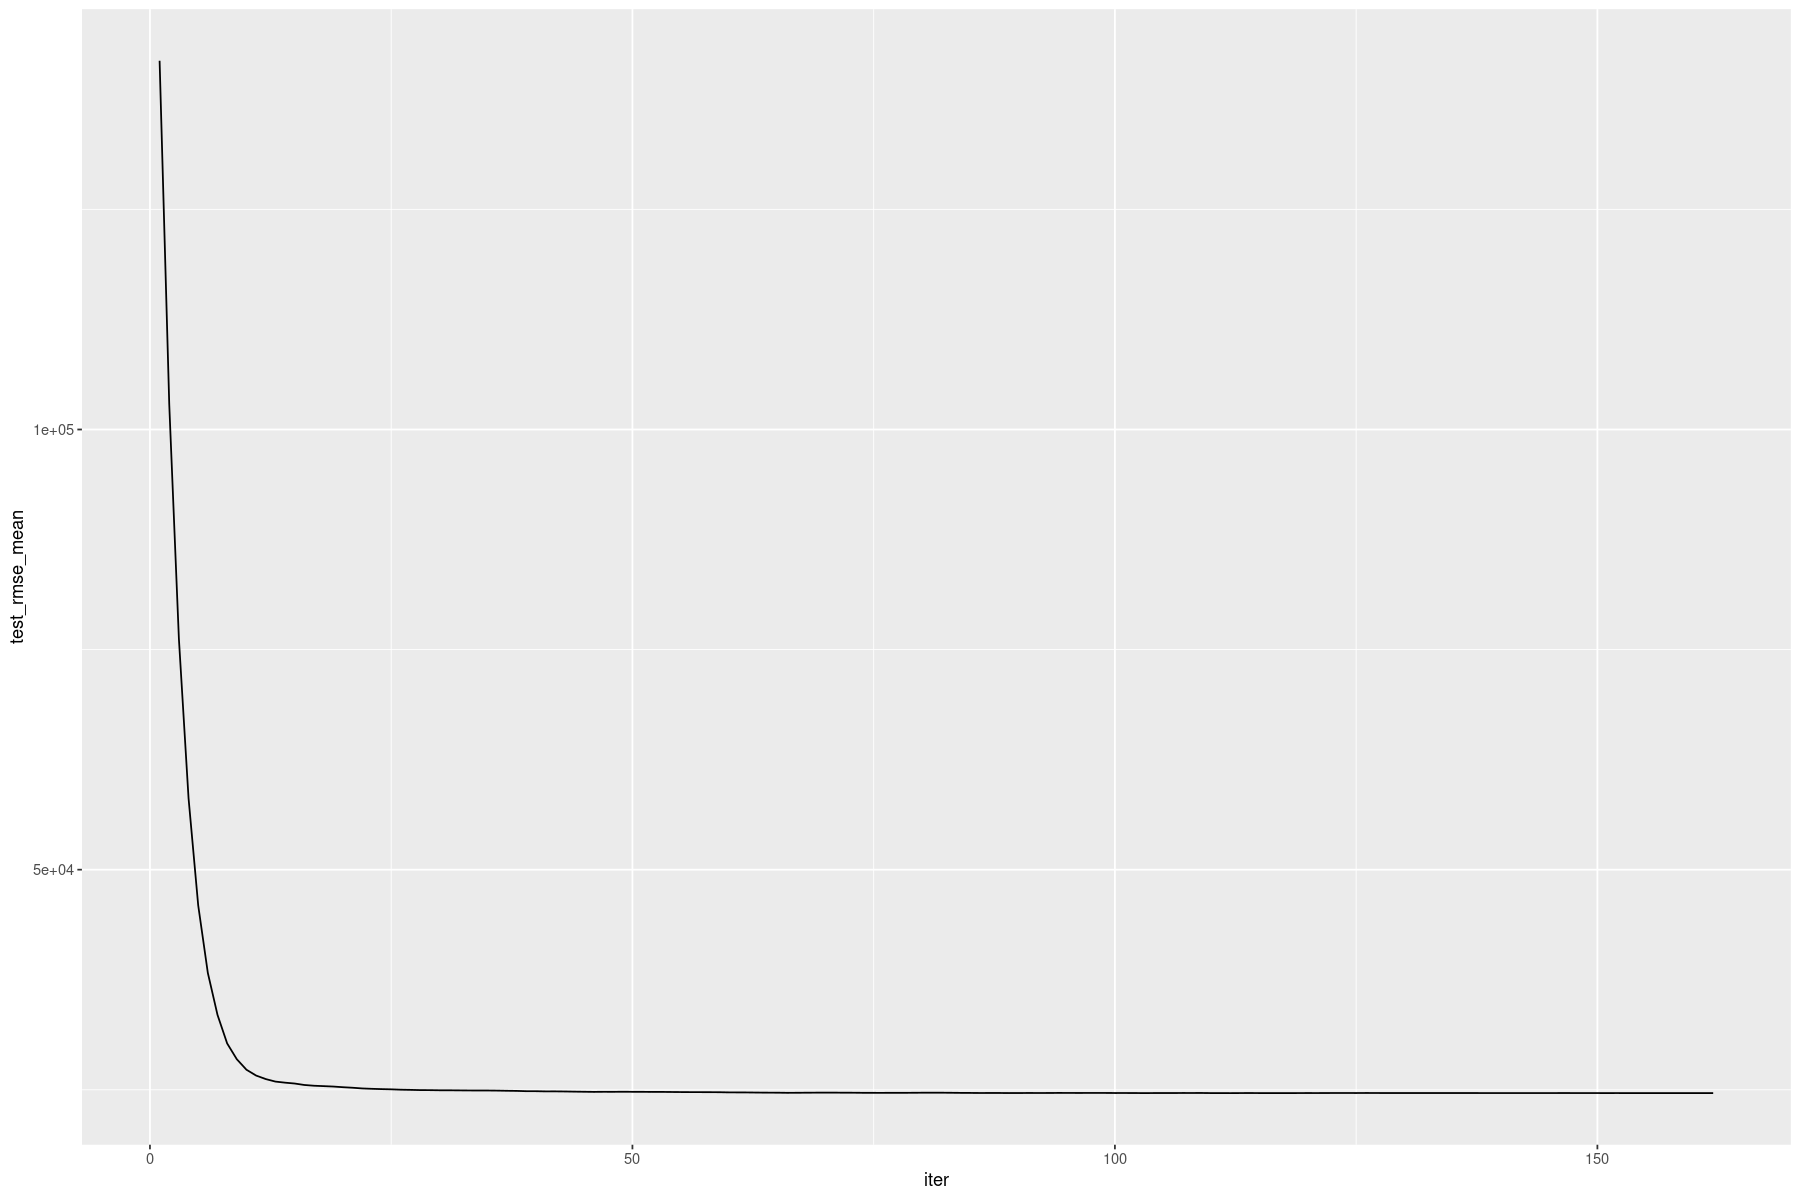

In [51]:
set.seed(123)
ames_xgb <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 2000,
  objective = "reg:squarederror",
  early_stopping_rounds = 50, 
  nfold = 5,
  params = list(
    eta = 0.3,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1),
  verbose = 0
)  

# minimum test CV RMSE


paste('min train error ->',min(ames_xgb$evaluation_log$test_rmse_mean))

ames_xgb$evaluation_log %>% 
    ggplot(aes(iter, test_rmse_mean)) + geom_line()

[1] "min train error -> 22729.3507812"

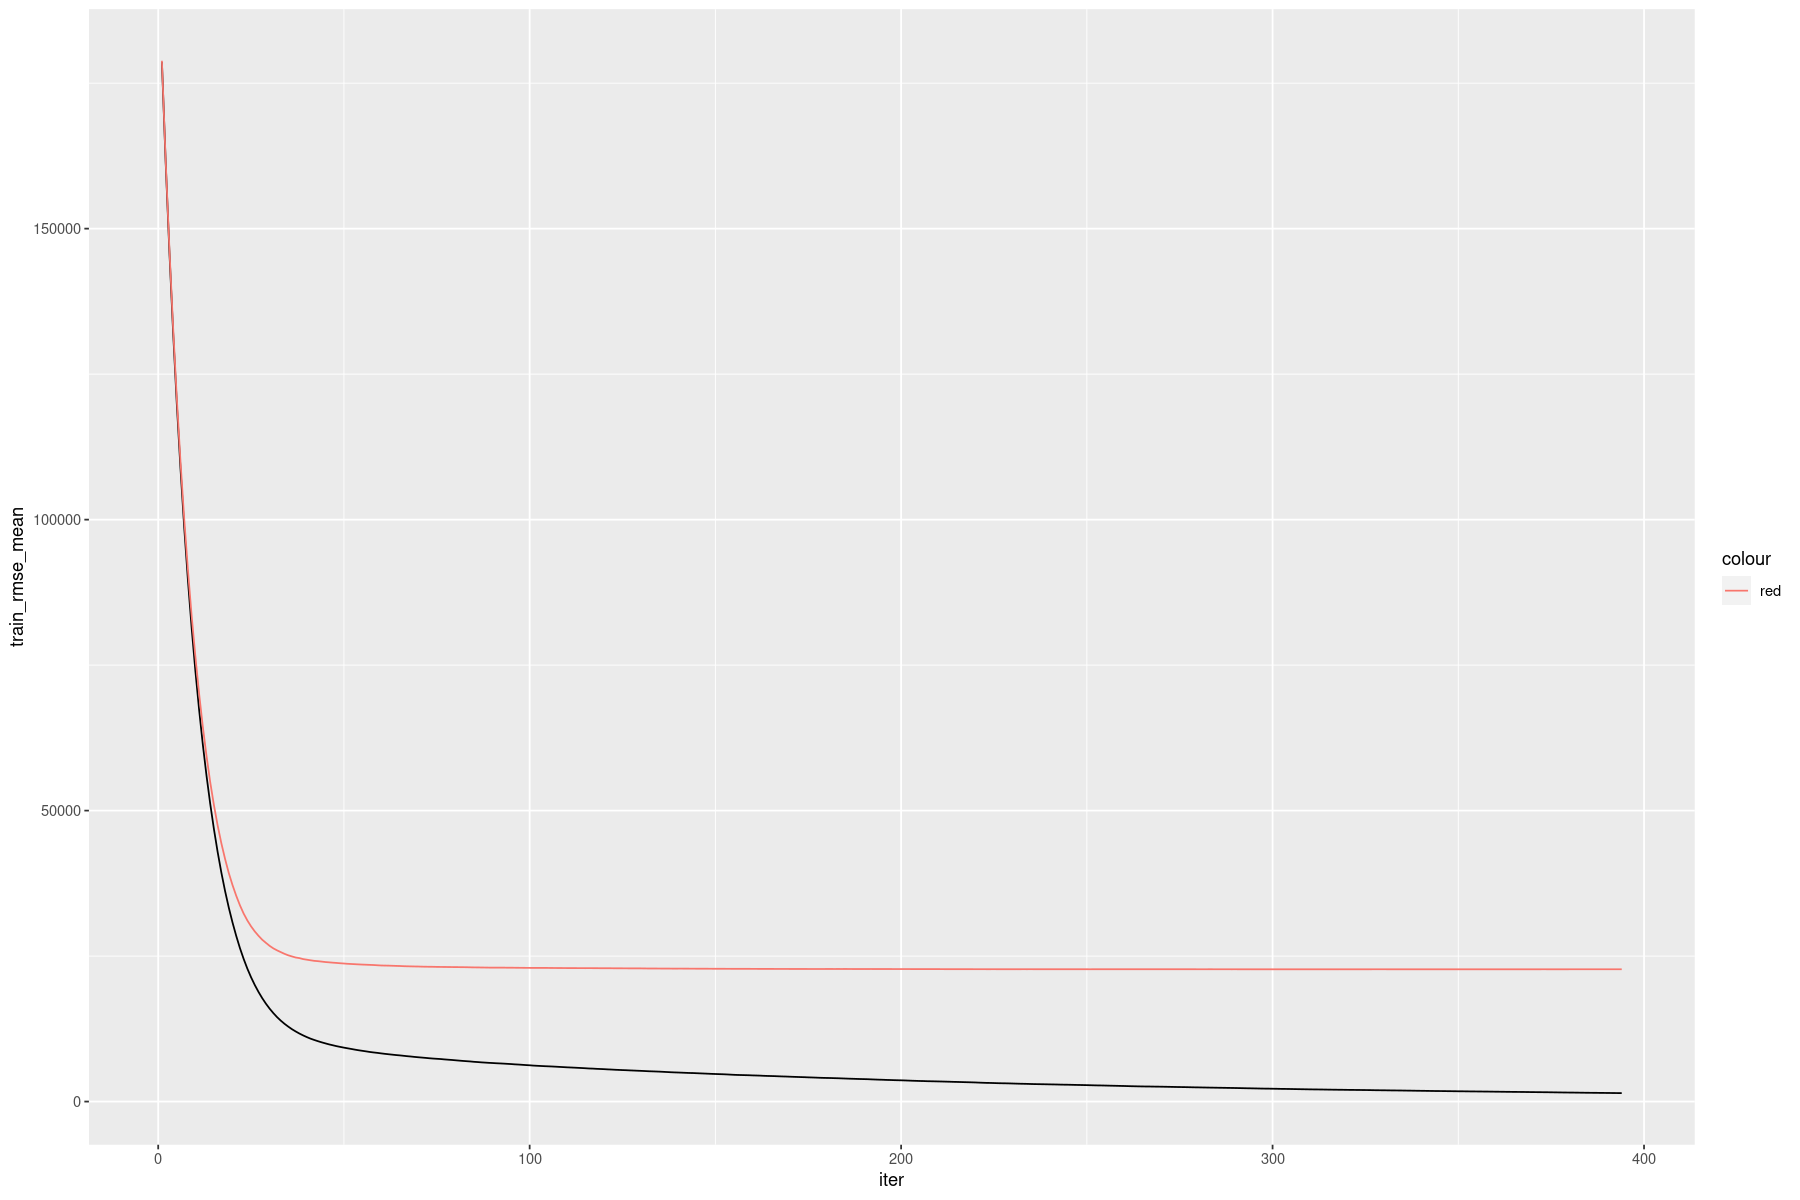

In [52]:
set.seed(123)
ames_xgb2 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 2000,
  objective = "reg:squarederror",
  early_stopping_rounds = 50, 
  nfold = 5,
  params = list(
    eta = 0.1,
    max_depth = 6,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1),
  verbose = 0
)  

paste('min train error ->',min(ames_xgb2$evaluation_log$test_rmse_mean))

ames_xgb2$evaluation_log %>% 
    ggplot(aes(iter, train_rmse_mean)) +
        geom_line() +
        geom_line(aes(iter, test_rmse_mean, color='red'))

In [53]:
# hyperparameter grid
hyper_grid1 <- expand.grid(
  eta = 0.1,
  max_depth = c(1, 3, 5, 9), 
  min_child_weight = c(1, 3, 6),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid1))) {
  set.seed(123)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 2000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid1$eta[i], 
      max_depth = hyper_grid1$max_depth[i],
      min_child_weight = hyper_grid1$min_child_weight[i],
      subsample = hyper_grid1$subsample[i],
      colsample_bytree = hyper_grid1$colsample_bytree[i],
      gamma = hyper_grid1$gamma[i], 
      lambda = hyper_grid1$lambda[i], 
      alpha = hyper_grid1$alpha[i]
    ) 
  )
  hyper_grid1$rmse[i] <- min(model$evaluation_log$test_rmse_mean)
  hyper_grid1$trees[i] <- model$best_iteration
    
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

# results
hyper_grid1 %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"
[1] "iteration  10"
[1] "iteration  11"
[1] "iteration  12"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
1,0.1,3,6,1,1,0,0,0,NA,NA,595,22412.44
2,0.1,3,3,1,1,0,0,0,NA,NA,471,22665.19
3,0.1,5,1,1,1,0,0,0,NA,NA,288,22742.85
4,0.1,5,3,1,1,0,0,0,NA,NA,383,22890.54
5,0.1,3,1,1,1,0,0,0,NA,NA,422,23193.21
6,0.1,5,6,1,1,0,0,0,NA,NA,311,23805.82


In [54]:
# hyperparameter grid
hyper_grid1_2 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = c(6, 9, 12),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid1_2))) {
  set.seed(123)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 2000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid1_2$eta[i], 
      max_depth = hyper_grid1_2$max_depth[i],
      min_child_weight = hyper_grid1_2$min_child_weight[i],
      subsample = hyper_grid1_2$subsample[i],
      colsample_bytree = hyper_grid1_2$colsample_bytree[i],
      gamma = hyper_grid1_2$gamma[i], 
      lambda = hyper_grid1_2$lambda[i], 
      alpha = hyper_grid1_2$alpha[i]
    ) 
  )
  hyper_grid1_2$rmse[i] <- min(model$evaluation_log$test_rmse_mean)
  hyper_grid1_2$trees[i] <- model$best_iteration
    
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

# results
hyper_grid1_2 %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
1,0.1,3,9,1,1,0,0,0,NA,NA,641,22089.72
2,0.1,3,6,1,1,0,0,0,NA,NA,595,22412.44
3,0.1,3,12,1,1,0,0,0,NA,NA,619,22709.78


In [55]:
# hyperparameter grid
hyper_grid2 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 9,
  colsample_bytree = c(0.5, 0.7, 0.9),
  subsample = c(0.5, 0.7, 0.9),
  gamma = 0,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid2))) {
  set.seed(123)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 2000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid1$eta[i], 
      max_depth = hyper_grid2$max_depth[i],
      min_child_weight = hyper_grid2$min_child_weight[i],
      subsample = hyper_grid2$subsample[i],
      colsample_bytree = hyper_grid2$colsample_bytree[i],
      gamma = hyper_grid2$gamma[i], 
      lambda = hyper_grid2$lambda[i], 
      alpha = hyper_grid2$alpha[i]
    ) 
  )
  hyper_grid2$rmse[i] <- min(model$evaluation_log$test_rmse_mean)
  hyper_grid2$trees[i] <- model$best_iteration
    
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

# results
hyper_grid2 %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
1,0.1,3,9,0.5,0.9,0,0,0,NA,NA,704,21813.37
2,0.1,3,9,0.5,0.5,0,0,0,NA,NA,760,22024.76
3,0.1,3,9,0.7,0.9,0,0,0,NA,NA,797,22070.60
4,0.1,3,9,0.7,0.7,0,0,0,NA,NA,793,22145.30
5,0.1,3,9,0.9,0.5,0,0,0,NA,NA,544,22212.45
6,0.1,3,9,0.9,0.9,0,0,0,NA,NA,594,22223.99


In [56]:
# hyperparameter grid
hyper_grid3 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 9,
  colsample_bytree = 0.5,
  subsample = 0.9,
  gamma = seq(0, 0.5, 0.1),
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid3))) {
  set.seed(123)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 2000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid3$eta[i], 
      max_depth = hyper_grid3$max_depth[i],
      min_child_weight = hyper_grid3$min_child_weight[i],
      subsample = hyper_grid3$subsample[i],
      colsample_bytree = hyper_grid3$colsample_bytree[i],
      gamma = hyper_grid3$gamma[i], 
      lambda = hyper_grid3$lambda[i], 
      alpha = hyper_grid3$alpha[i]
    ) 
  )
  hyper_grid3$rmse[i] <- min(model$evaluation_log$test_rmse_mean)
  hyper_grid3$trees[i] <- model$best_iteration
    
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

# results
hyper_grid3 %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>
1,0.1,3,9,0.5,0.9,0.0,0,0,NA,NA,704,21813.37
2,0.1,3,9,0.5,0.9,0.2,0,0,NA,NA,704,21813.37
3,0.1,3,9,0.5,0.9,0.5,0,0,NA,NA,704,21813.37
4,0.1,3,9,0.5,0.9,0.1,0,0,NA,NA,704,21813.37
5,0.1,3,9,0.5,0.9,0.3,0,0,NA,NA,704,21813.37
6,0.1,3,9,0.5,0.9,0.4,0,0,NA,NA,704,21813.37


[1] 1249

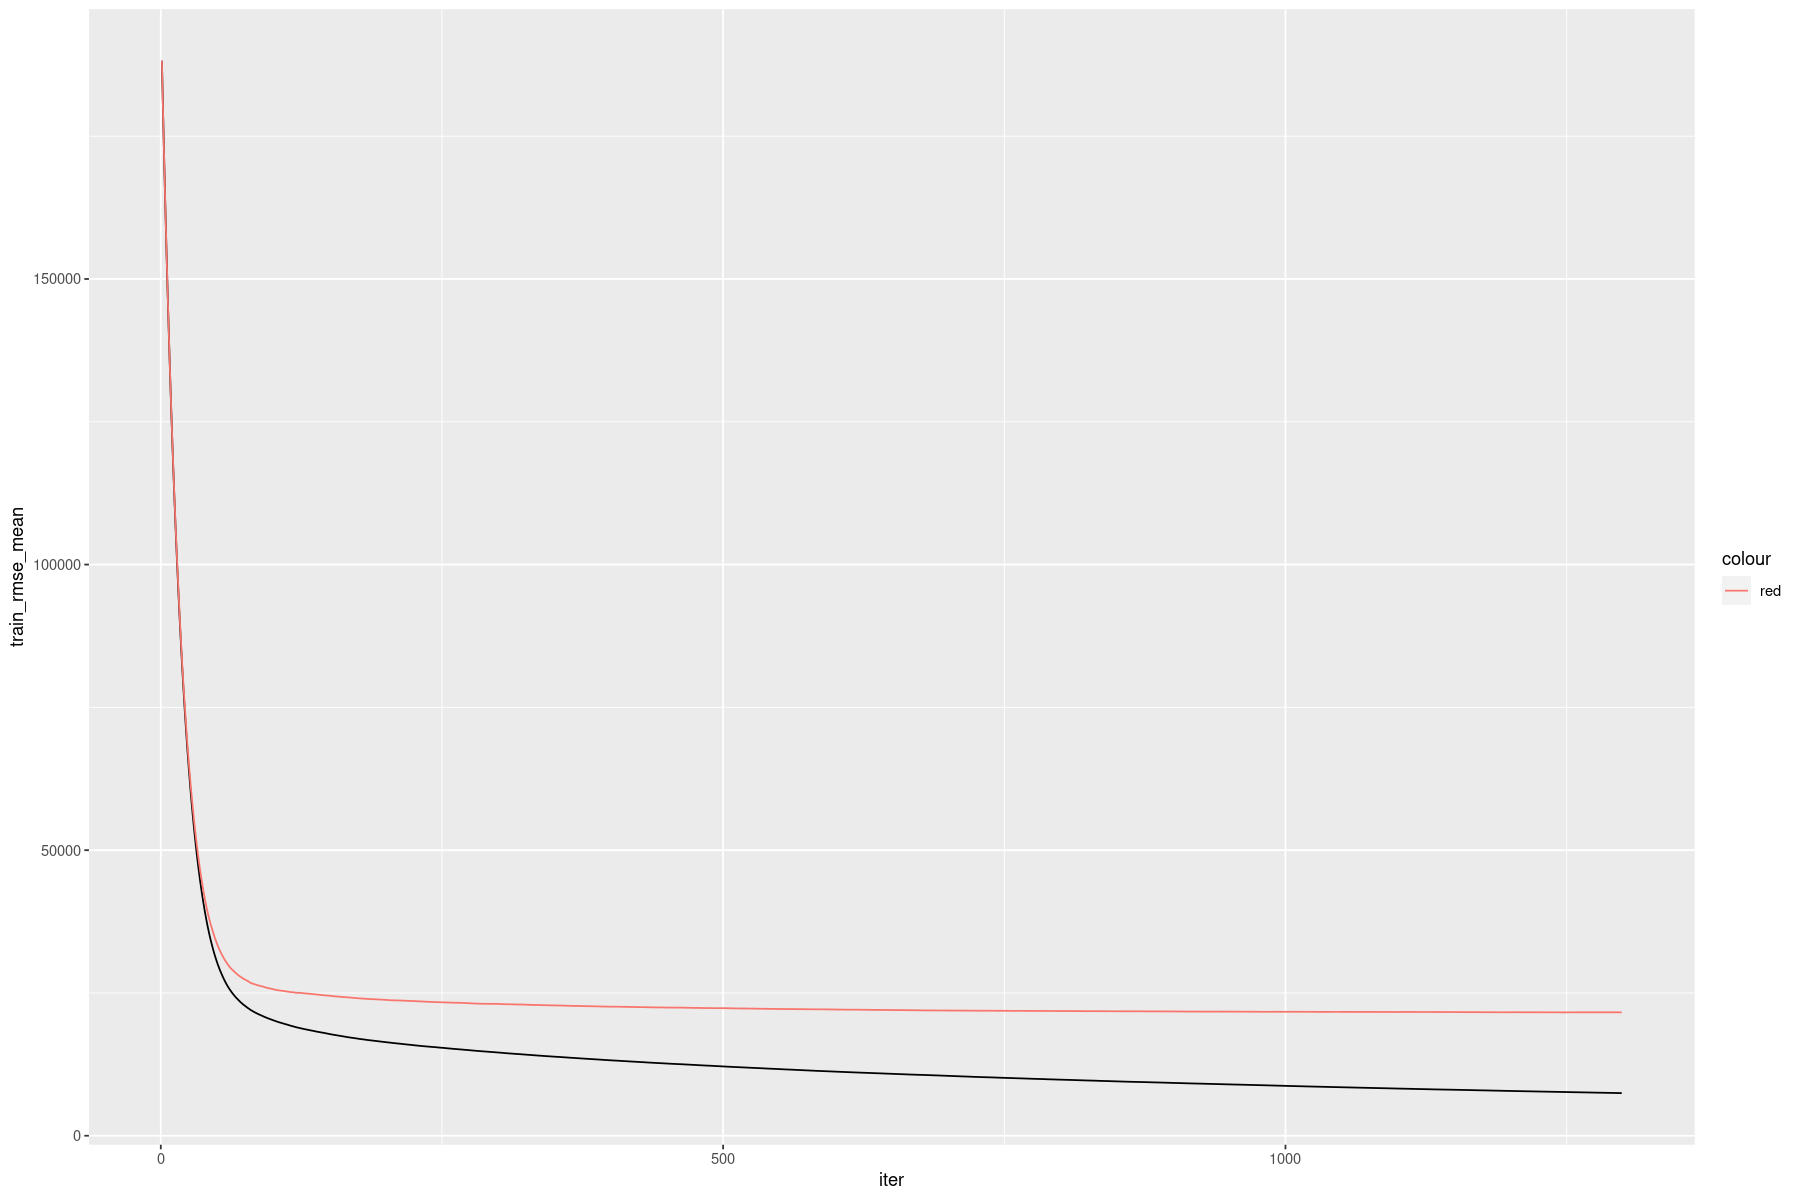

In [57]:
set.seed(123)
params <- list(
  eta = 0.05,
  max_depth = 3,
  min_child_weight = 9,
  subsample = 0.9,
  colsample_bytree = 0.5,
  gamma = 0
)

# train final model
xgb_final_cv <- xgb.cv(
  params = params,
  data = X_train,
  label = Y_train,
  nrounds = 2000,
  objective = "reg:squarederror",
  early_stopping_rounds = 50, 
  nfold = 5,
  verbose = 0
)
xgb_final_cv$best_iteration

xgb_final_cv$evaluation_log %>% 
    ggplot(aes(iter, train_rmse_mean)) +
        geom_line() +
        geom_line(aes(iter, test_rmse_mean, color='red'))

In [58]:
set.seed(123)
params <- list(
  eta = 0.05,
  max_depth = 3,
  min_child_weight = 9,
  subsample = 0.9,
  colsample_bytree = 0.5,
  gamma = 0
)

# train final model
xgb_final <- xgboost(
  params = params,
  data = X_train,
  label = Y_train,
  nrounds = 1249,
  objective = "reg:squarederror",
  verbose = 0
)

### Feature interpretation

Al igual que RF, GBM implementan impurity para obtener las features que más influyen en la reducción de la loss en la predicción. Sin embargo XGBoost implementa un par mas:

* **Gain**: es el equivalente al usado en RF (impurity)
* **Coverage**: cuantifica el número relativo de observaciones que se usó de una feature para llegar a una hoja.
* **Frequency**: Porcentaje del número de veces que una feature fue usada para hacer un split entre todos los árboles


In [59]:
importances <- xgb.importance(model=xgb_final)

In [60]:
head(importances)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Overall_Qual,0.44224832,0.048794453,0.037792278
Gr_Liv_Area,0.12562682,0.062780847,0.062398042
Garage_Cars,0.06486456,0.011009049,0.009651985
Total_Bsmt_SF,0.05314194,0.056477899,0.054105492
First_Flr_SF,0.04173593,0.033569852,0.035889070
Bsmt_Qual,0.03929485,0.004716229,0.005709625


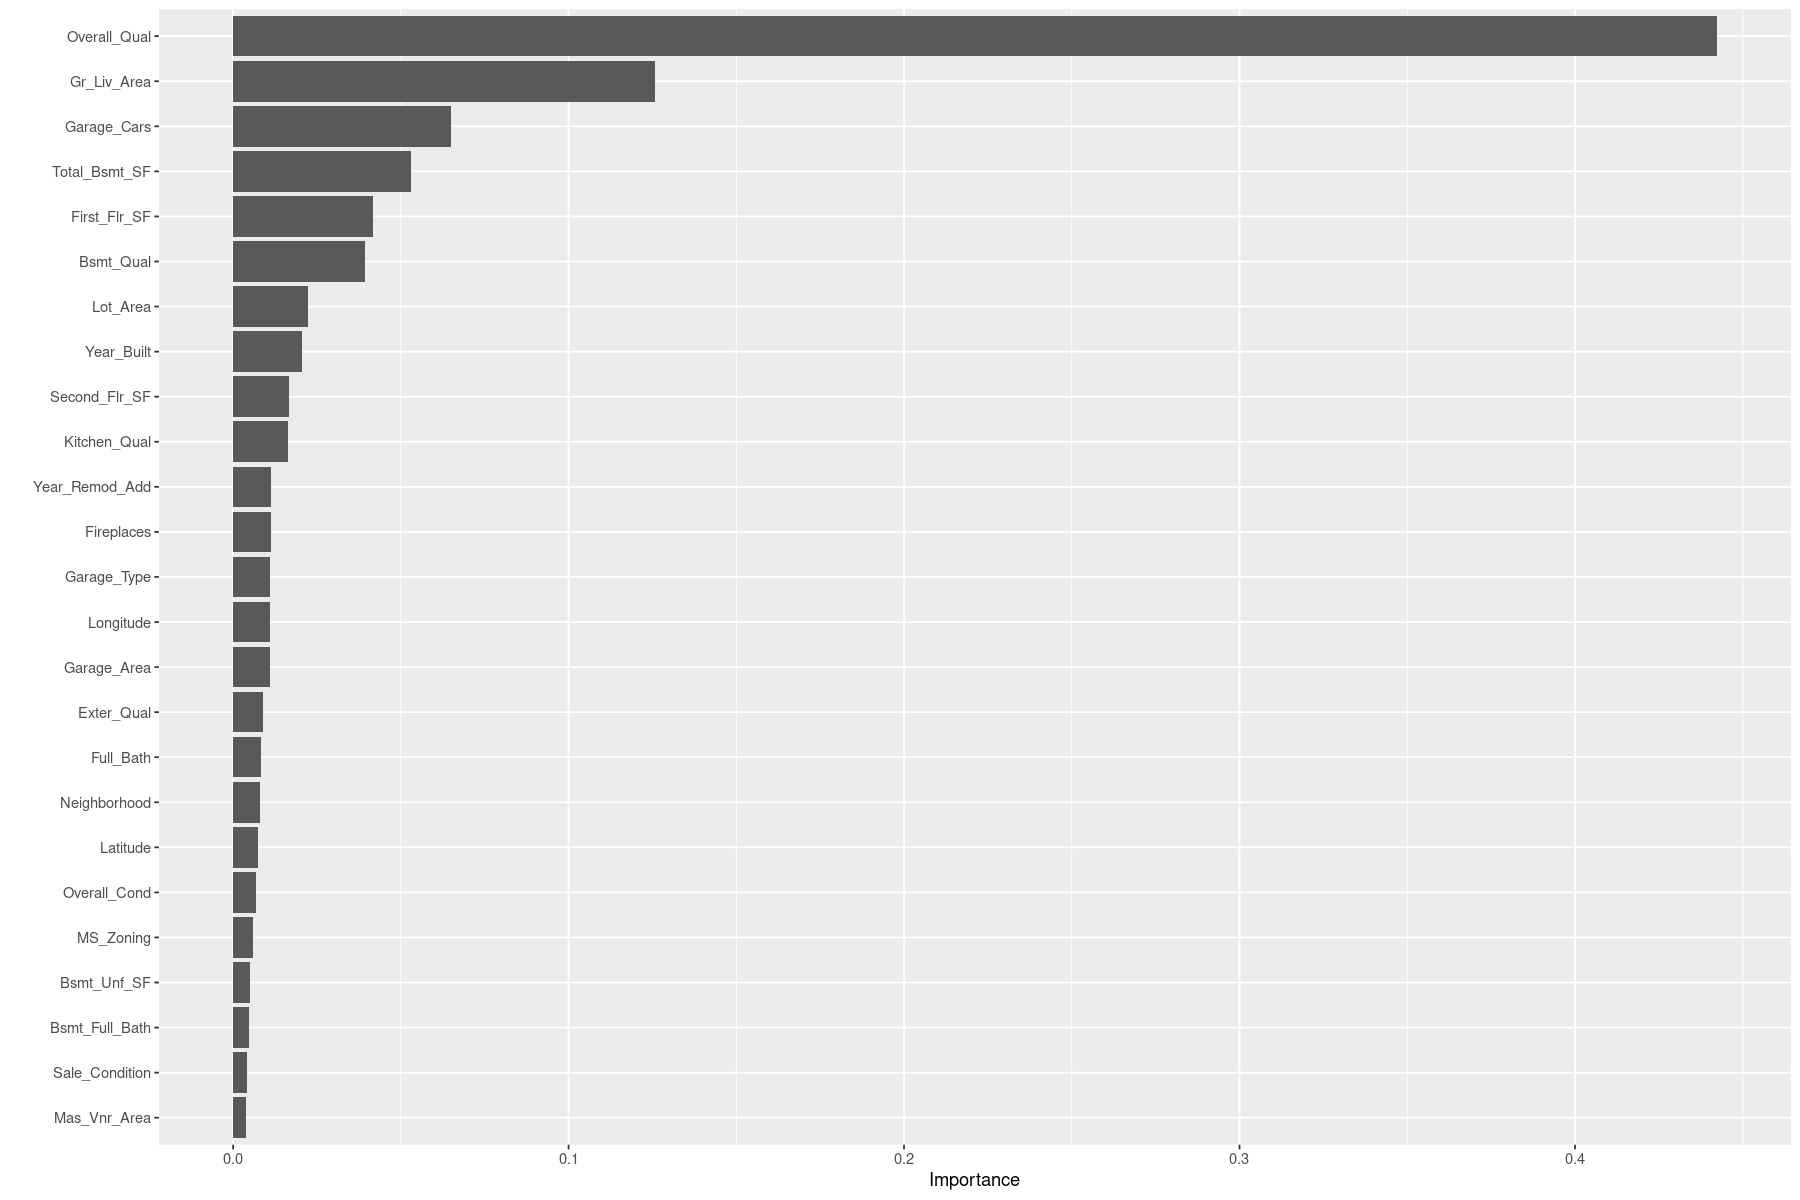

In [61]:
vip::vip(xgb_final, type="gain", num_features = 25)

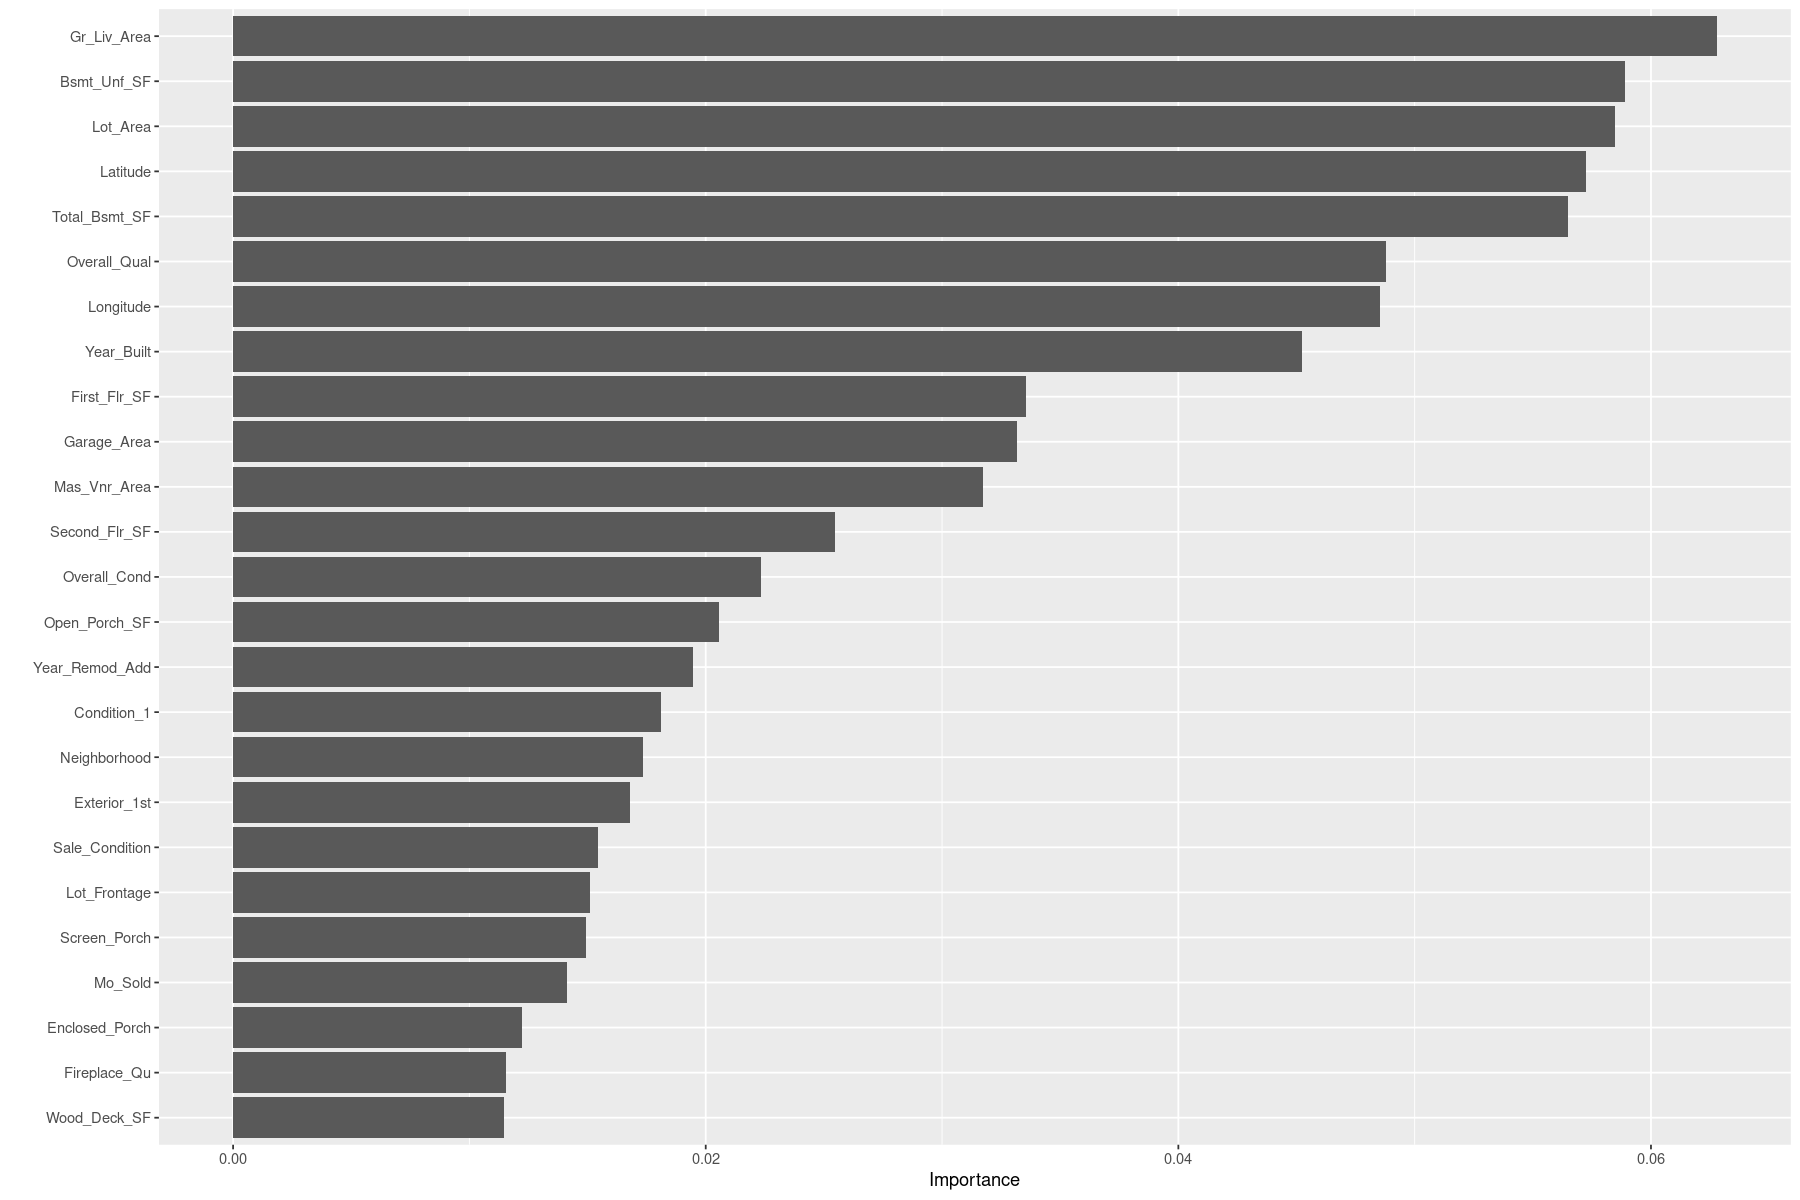

In [62]:
vip::vip(xgb_final, type="cover", num_features = 25)

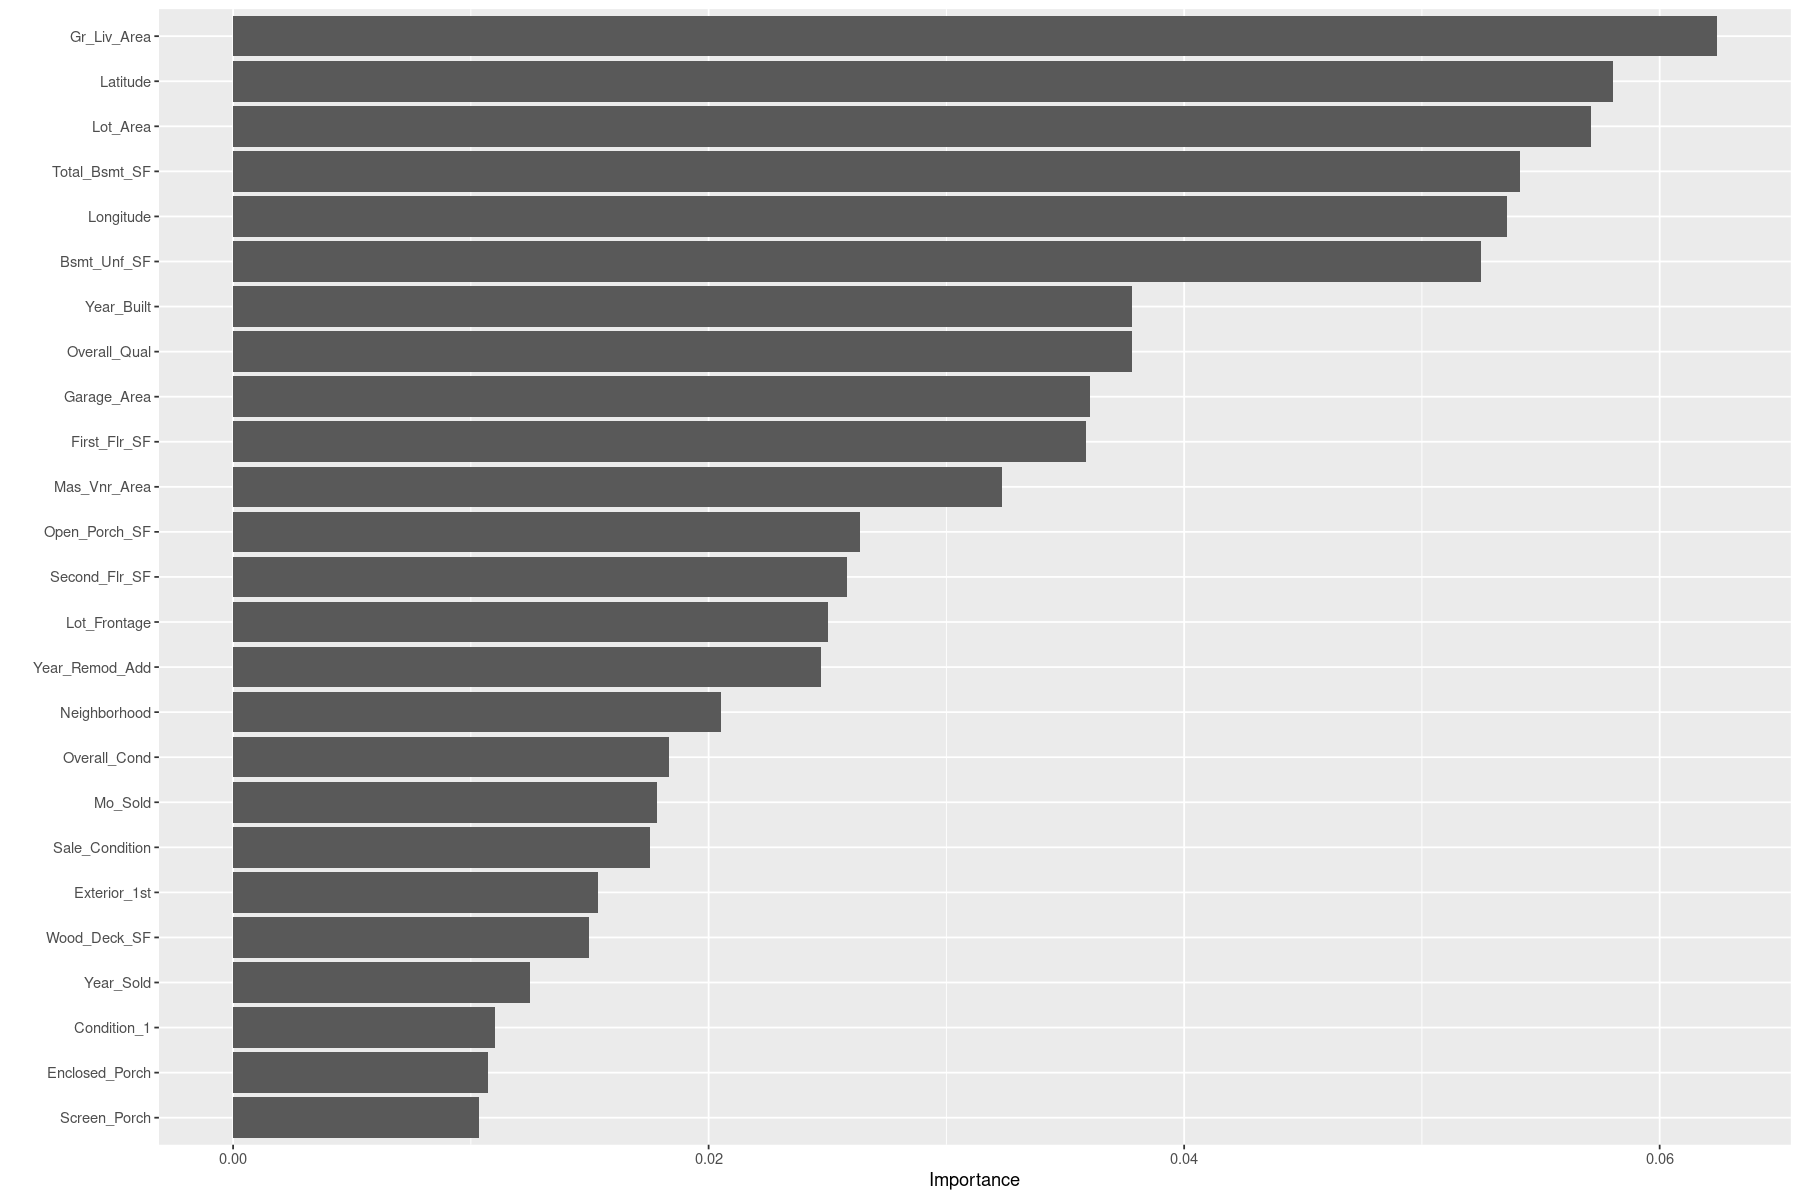

In [63]:
vip::vip(xgb_final, type="frequency", num_features = 25)